In [170]:
# Standard Imports
import numpy as np
import pandas as pd
import tensorflow as tf
print("TF Version:", tf.__version__)
import sklearn.preprocessing as pre
import math
import matplotlib.pyplot as plt

TF Version: 2.0.0


# Kaggle Titanic Competition

So the goal is to predict whether, given a set of features of a given passenger aboard the titanic, they would have survived the shipwreck or not.

The training data is comprised of these features for a collection of passengers, and whether they survived or not. Let's take a look at the data.

In [320]:
raw_train = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')

## Preparing the data
### Selecting features
We can make the assumption that key fields, that contain unique values for each entry, are not useful sources of information, and will not be included in our feature representation. These are:
- `PassengerId`
- `Name`
- `Ticket`

Futher, we have holes in our data. The `Cabin` field is very sparsely populated, and the `Age` field is empty for about an 8th of our examples:

In [321]:
raw_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There's not much we can do about the `Cabin` field. So we'll simply ignore it.

Since the `Age` field has onyl a small amount of empty entries, we can approach this the following way:
- Train a model `A` to estimate the missing ages, given the rest of the features
- Fill in the gaps in the train and test data with model `A`
- Train model `B` on to classify passengers as survived or not
- Predict survived passengers from test data

Our feature vectors will look like this:
- $v_1$: Passenger Class
- $v_2$: Sex $\in \{0,1\}$
- $v_3$: Age
- $v_4$: Sib-Spouse Count
- $v_5$: Parent-Child Count
- $v_6$: Fare
- $v_7$: Embarked $\in \{0,1,2\}$

Each of our feature vectors will then be normalized (by scaling them to standard normal distribution)

In [325]:
# Feature representations

relevant_fields = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
f_id = lambda x: x

# Initially all encodings are just identity
base_map = { feat:f_id for feat in relevant_fields }

# Specific categorical encodings for sex and embark
base_map["Sex"] = lambda x: 0 if x == "male" else 1
base_map["Embarked"] = lambda x: 0 if x == "C" else 1 if x == "Q" else 2

def mkrep(p,feat_map):
    vec = np.empty(len(feat_map))
    
    for i, (feat, f) in enumerate(feat_map.items()):
        vec[i] = f(p[feat])
    
    return vec

def feat_reps(data, feat_map):
    reps = np.empty((len(data), len(feat_map)))
    for i in range(len(data)):
        reps[i] = mkrep(data.iloc[i], feat_map)
    return reps

def standard_scale(feats):
    scaler = pre.StandardScaler().fit(feats)
    return scaler.transform(feats)

def mk_dataset(df, feat_map, label=None, norm=None):
    reps = feat_reps(df, feat_map)
    reps_norm = norm(reps) if not norm is None else reps
    labels = df[label].values
    
    if not label is None:
        labels = df[label].values
        return reps_norm, labels
    else:
        return reps_norm

We'll filter all our data to only contain relevant information. These will be our original, unadulterated data sources.

In [326]:
TRAIN = raw_train[relevant_fields]
TEST = raw_test[relevant_fields]

### Model A - Estimating age
Real values? This sounds like a job for linear regression! Our features will be given by all previously stated features, except age. We'll select all data where age is available, and make a 70:30 train:test split.

In [334]:
# We train model A on both original train and test data,
# since the train-test split for the original classification
# problem holds no relevance for the Age subproblem

combined = pd.concat([TRAIN, TEST])

modelA_map = { k:v for k,v in base_map.items() if k != "Age" }
valid_ages = combined[combined.Age.notnull()]

data_A, labels_A = mk_dataset(valid_ages, modelA_map, label="Age", norm=standard_scale)

train_AX = data_A[:800]
train_AY = labels_A[:800]

test_AX = data_A[800:]
test_AY = labels_A[800:]

## Classifying survived passengers

In [165]:
# Passengers without age field
sel_WA = ["Pclass","Sex","SibSp","Parch","Fare","Embarked"]
train_WA = mk_dataset(train_raw, 7, mk_rep_WA, subset=sel_WA)
labels_WA = train_raw.Survived.values
test_WA = mk_dataset(test_raw, 7, mk_rep_WA, subset=sel_WA)

Alright. So far we've got our data preprocessing pipeline and a dataset to fit on. This scenario will be the benchmark for our model to measure against.

## The Model
This is a binary classification problem. So we know our output layer's activation will be sigmoid, and our loss function will be cross entropy (negative log likelihood),

In [214]:
# Utility Logger
model_v1 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(14, input_shape=(7,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
])

model_v1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 1000

hist_WA = model_v1.fit(
    train_WA, labels_WA,
    batch_size=16, epochs=EPOCHS,
    validation_split=0.2,
    use_multiprocessing=True,
    verbose=0
)

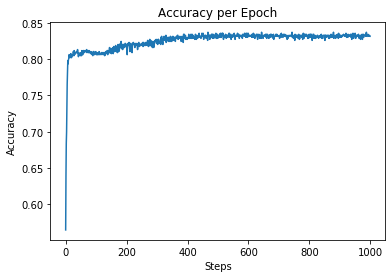

In [215]:
loss_hist = hist_WA.history['loss']
acc_hist = hist_WA.history['accuracy']

plt.plot(acc_hist)
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.show()